https://inclass.kaggle.com/c/dota-2-win-probability-prediction

## Градиентный бустинг в лоб

In [22]:
%matplotlib inline
import datetime
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [14]:
test = pd.read_csv('data/features_test.csv.zip', index_col='match_id')
train = pd.read_csv('data/features.csv.zip', index_col='match_id')
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


Найдем колонки в которых пропущены данные.

In [3]:
[i for i, v in train.count().iteritems() if v < 97230]

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

Так как у нас есть только первые 5 минут игры, то некоторые характеристки еще не были заполнены. Напрмимер, время покупки курьера или first blood. Эти пропуски можно заполнить нулями. (Проверял более умное заполнение, например отрицательным числом и прочее - не влияет)

In [3]:
train.fillna(0, inplace=True)
y = train['radiant_win']
X = train.drop(['start_time', 'duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire',
                           'barracks_status_radiant', 'barracks_status_dire'], axis=1)

test.fillna(0, inplace=True)
X_test = test.drop(['start_time'], axis=1)

In [204]:
def testGBC(X, y, kfold, num_tree):
    clf = GradientBoostingClassifier(n_estimators=num_tree, random_state=42, verbose=False)
    start_time = datetime.datetime.now()
    score = cross_val_score(clf, X, y, cv=kfold, scoring='roc_auc')
    end_time = datetime.datetime.now()
    print("%s) time to fit = %s; ROC_AUC = %s\n" %
          (num_tree, end_time-start_time, score.mean()))
    
def describeImportance(clf, X):
    indices = np.argsort(clf.feature_importances_)[::-1]
    for f in range(X.shape[1]):
        print('%d. feature %d %s (%f)' % (f + 1, indices[f], X.columns[indices[f]],
                                          clf.feature_importances_[indices[f]]))

def trainGBC(X, y):
    clf = GradientBoostingClassifier(n_estimators=50, random_state=42, verbose=False)
    start_time = datetime.datetime.now()
    clf.fit(X, y)
    end_time = datetime.datetime.now()
    print("Testing data) time to fit = %s;", end_time-start_time)
    return clf

In [6]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for num_tree in [10,20,30,40,50]:
    testGBC(X, y, kfold, num_tree)

10) time to fit = 0:00:32.763168; ROC_AUC = 0.664850687975

20) time to fit = 0:00:59.053800; ROC_AUC = 0.682461876804

30) time to fit = 0:01:27.755503; ROC_AUC = 0.690006471039

40) time to fit = 0:01:54.582916; ROC_AUC = 0.693941559672

50) time to fit = 0:02:22.777606; ROC_AUC = 0.697493744081



Подбор количества деревьев показал, что при дальнейшем увеличении, эффект возможно будет, но слишком незначительный по сравнению с временем работы алгоритма обучения. Слишком долго ждать ради возможных 0.002 не хочется.

Весьма интересно узнать, какими признаками пользовался алгоритм для классификации, т.е. узнать важность признаков.
Стоит отметить, что в основном важны:
    
- деньги
- ботинки
- курьеры
- first blood
- свитки телепортации!
- опыт

Это натолкнуло меня на мысль, что хорошо бы убрать ненужные признаки или хотя бы как-то объединить существующие.
Экспериментальным путём я понял, что не так важно золото каждого игрока, как важно общее золото команды. То же касается и опыта.
Возможно при хитром алгоритме, который будет учитывать "качество" героя, понадобится детальная информация о каждом игроке, но в данном случае лучше провести такую оптимизацию.

In [7]:
gbc = trainGBC(X, y)
describeImportance(gbc, X)
pred = gbc.predict_proba(X_test)[:, 1]

Testing data) time to fit = %s; 0:00:38.200458
1. feature 76 d5_gold (0.092144)
2. feature 52 d2_gold (0.091675)
3. feature 12 r2_gold (0.085039)
4. feature 44 d1_gold (0.084979)
5. feature 28 r4_gold (0.084723)
6. feature 4 r1_gold (0.083765)
7. feature 68 d4_gold (0.079843)
8. feature 20 r3_gold (0.079053)
9. feature 36 r5_gold (0.077562)
10. feature 60 d3_gold (0.071788)
11. feature 83 first_blood_player1 (0.033225)
12. feature 89 radiant_boots_count (0.028435)
13. feature 97 dire_boots_count (0.021370)
14. feature 87 radiant_flying_courier_time (0.012335)
15. feature 37 r5_lh (0.010165)
16. feature 13 r2_lh (0.009575)
17. feature 96 dire_tpscroll_count (0.007485)
18. feature 61 d3_lh (0.006924)
19. feature 69 d4_lh (0.006900)
20. feature 45 d1_lh (0.006542)
21. feature 29 r4_lh (0.006232)
22. feature 5 r1_lh (0.003429)
23. feature 100 dire_first_ward_time (0.002416)
24. feature 31 r4_deaths (0.001953)
25. feature 88 radiant_tpscroll_count (0.001472)
26. feature 71 d4_deaths (0.0014

In [198]:
"""Метод для подготовки данных. Убирает все ненужные признаки, оставляет только полезные и проводит аггрегацию некоторых.
"""
def prepareData(X):
    X_ = pd.DataFrame()
    
    #X_['first_blood_team'] = X['first_blood_team']
    
    dire_gold = X['d5_gold'] + X['d4_gold'] + X['d3_gold'] + X['d2_gold'] + X['d1_gold']
    radiant_gold = X['r5_gold'] + X['r4_gold'] + X['r3_gold'] + X['r2_gold'] + X['r1_gold']
    X_['gold_delta'] = dire_gold - radiant_gold
    
    dire_lh = X['d5_lh'] + X['d4_lh'] + X['d3_lh']+ X['d2_lh'] +X['d1_lh']
    radiant_lh = X['r5_lh'] + X['r4_lh'] + X['r3_lh']+ X['r2_lh'] +X['r1_lh']
    X_['lh_delta'] = dire_lh - radiant_lh
    
    dire_items = X['d5_items'] + X['d4_items'] + X['d3_items'] + X['d2_items'] + X['d1_items'] 
    radiant_items = X['r5_items'] + X['r4_items'] + X['r3_items'] + X['r2_items'] + X['r1_items']
    X_['items_delta'] = dire_items - radiant_items
    
    dire_boots_count = X['dire_boots_count']
    radiant_boots_count = X['radiant_boots_count']
    X_['boots_count_delta'] = dire_boots_count - radiant_boots_count
    
    dire_xp = X['d5_xp'] + X['d4_xp'] + X['d3_xp'] + X['d2_xp'] + X['d1_xp']
    radiant_xp = X['r5_xp'] + X['r4_xp'] + X['r3_xp'] + X['r2_xp'] + X['r1_xp']
    X_['xp_delta'] = dire_xp - radiant_xp
    
    dire_kills = X['d5_kills'] + X['d4_kills'] + X['d3_kills'] + X['d2_kills'] + X['d1_kills']
    radiant_kills = X['r5_kills'] + X['r4_kills'] + X['r3_kills'] + X['r2_kills'] + X['r1_kills']
    X_['kills_delta'] = dire_kills - radiant_kills
    
    X_['tpscroll_count_delta'] = X['dire_tpscroll_count'] - X['radiant_tpscroll_count']

    X_['bottle_time_delta'] = X['dire_bottle_time'] - X['radiant_bottle_time']
    X_['flying_courier_time_delta'] = X['dire_flying_courier_time'] - X['radiant_flying_courier_time']
    X_['courier_time_delta'] = X['dire_courier_time'] - X['radiant_courier_time']
    X_['first_ward_time_delta'] = X['dire_first_ward_time'] - X['radiant_first_ward_time']
    
    return X_

In [205]:
def hypothesis_drop_unused(X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    X_ = prepareData(X)
    testGBC(X_, y, kfold, num_tree=50)
    gbc = trainGBC(X_, y)
    describeImportance(gbc, X_)
    pred = gbc.predict_proba(prepareData(X_test))[:, 1]
    return pred

In [200]:
prepareData(X).head()

,gold_delta,lh_delta,items_delta,boots_count_delta,xp_delta,kills_delta,tpscroll_count_delta,bottle_time_delta,flying_courier_time_delta,courier_time_delta,first_ward_time_delta
match_id,,,,,,,,,,,
0,-1,2,-4,2,-443,1,1,-31.0,-23.0,-4.0,-87.0
1,807,-2,3,4,-144,1,3,-24.0,195.0,-4.0,15.0
2,-891,-11,3,-1,-932,-1,1,-18.0,221.0,5.0,52.0
3,421,9,8,1,-183,0,0,-84.0,184.0,-5.0,57.0
4,180,15,-2,-1,511,-2,5,16.0,44.0,1.0,-62.0


In [206]:
pred = hypothesis_drop_unused(X, y)

50) time to fit = 0:00:26.145645; ROC_AUC = 0.716188300875

Testing data) time to fit = %s; 0:00:06.629327
1. feature 0 gold_delta (0.339183)
2. feature 1 lh_delta (0.160131)
3. feature 4 xp_delta (0.134114)
4. feature 10 first_ward_time_delta (0.082771)
5. feature 2 items_delta (0.076148)
6. feature 9 courier_time_delta (0.051889)
7. feature 7 bottle_time_delta (0.050842)
8. feature 8 flying_courier_time_delta (0.048745)
9. feature 6 tpscroll_count_delta (0.031802)
10. feature 3 boots_count_delta (0.022779)
11. feature 5 kills_delta (0.001597)


Метрика заметно улучшилась! вместо 0.69 теперь 0.71. Значит использование аггрегированных признаков было весьма хорошей идеей.

In [208]:
"""Функция сохранения предсказаний в файл.
"""
def save(fname, pred, test):
    res1 = pd.DataFrame()
    res1['match_id'] = test.index
    res1['radiant_win'] = pred
    res1.to_csv("submissions/{0}.csv".format(fname), index=False)
    res1

In [14]:
save("gb_without_unused", pred, X_test)

## Логистическая регрессия

In [210]:
"""Функция для подбора параметров логистической регрессии.
"""
def testLR(X, y):
    clf = LogisticRegression(random_state=42)
    # Так как логистические регрессии чувствительны к масштабу, проведем нормализацию признаков. 
    XX = StandardScaler().fit_transform(X)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = {'C': np.linspace(0.001,1,10)}
    grid_search = GridSearchCV(clf, grid, scoring='roc_auc', cv=kfold)
    grid_search.fit(XX, y)

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

In [211]:
"""Функция для обучения и предсказания результатов по полной выборке.
"""
def trainLR(X, y, X_test, C):
    clf = LogisticRegression(random_state=42, C=C)
    XX = StandardScaler().fit_transform(X)
    clf.fit(XX, y)
    XX_test = StandardScaler().fit_transform(X_test)
    return clf.predict_proba(XX_test)[:, 1]

In [212]:
testLR(X, y)

Best score: 0.7164096882227959
Best parameters: {'C': 0.112}


Логистическая регрессия оказалась сразу намного лучше градиентного бустинга. Но не сильно, всего лишь на 0.02. Но на подготовленных признаках отличий от GBC почти нет. Поэтому проверим как себя поведет линейная регрессия на подготовленных признаках.

Стоит заметить что функция `prepareData` удаляет все категориальные признаки, оставляя только регрессионные.

In [214]:
testLR(prepareData(X), y)

Best score: 0.7167732168772922
Best parameters: {'C': 0.77800000000000002}


Для подготовик мешка слов нужно знать сколько всего героев в игре.
Самое интересное то, что не все герои могли быть задействованы в тестовой обучающей выборке. Всего их должно быть 113, а countHeroes выдает 108. Поэтому далее используем только 113.

In [213]:
def countHeroes(X):
    heroes = ['{}{}_hero'.format(team, i + 1) for i in range(5) for team in ['r', 'd']]
    return np.unique(np.concatenate([X[h].unique() for h in heroes])).size

countHeroes(X)

108

In [10]:
def wordsBag(X, N):
    # N — количество различных героев в выборке
    X_pick = np.zeros((X.shape[0], N))

    for i, match_id in enumerate(X.index):
        for p in range(5):
            X_pick[i, X.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, X.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

    return X_pick

In [23]:
bag = wordsBag(X, 113)

Мне стало любопытно, а что можно предсказать используя только мешок слов линейной регрессией. Результат оказался впечатляющим - 0.6!

In [22]:
testLR(pd.DataFrame(bag, index=X.index), y)

Best score: 0.607769564074281
Best parameters: {'C': 1.0}


Добавим мешок слов к нашей подготовленной выборке и посмотрим насколько улучшится предсказание.

In [215]:
superX = pd.concat([pd.DataFrame(bag, index=X.index), prepareData(X)], axis=1)

In [216]:
testLR(superX, y)

Best score: 0.7520684718659247
Best parameters: {'C': 0.33400000000000002}


Очевидно, качество заметно улучшилось, так как выбор героев должен играть ключевую роль в долгосрочной перспективе игры.

In [25]:
bag_test = wordsBag(X_test, 113)
superX_test = pd.concat([pd.DataFrame(bag_test, index=X_test.index), prepareData(X_test)], axis=1)
pred = trainLR(superX, y, superX_test, 0.334)
save("lr_with_bag", pred, X_test) # 0.75490

# Случайный лес

In [26]:
def findParamsRFC(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    parameter_grid = {'n_estimators' : [20, 100],
                     'max_depth' : [20, 100],
                     'min_samples_split' : [2, 5],
                     'max_leaf_nodes' : [40, 60]
                    }
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=StratifiedKFold(5))
    grid_search.fit(X_train, y_train)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

In [27]:
findParamsRFC(superX.head(50), y.head(50))

Best score: 0.6285714285714286
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100, 'max_leaf_nodes': 40}


In [28]:
def trainRFC(X, y, X_test):
    clf = RandomForestClassifier(random_state=42, n_estimators=20)
    clf.fit(X, y)
    return clf.predict_proba(X_test)[:, 1]

In [29]:
pred = trainRFC(superX, y, superX_test)
save("rfc_with_bag", pred, X_test) # 0.70690

# Синергия героев
Предположительно, можно создать дополнительные признаки, которые будут учитывать синергию героев, т.е. их сочетаемость. 
Самая простая идея - это добавить некоторый признак "силы" команды, основываясь на "силе" отдельных героев, основываясь на величинах их средних побед отностиельно всех сыгранных матчей.
Далее оценивать силу пар игроков. Подсчет силы пар героев будет очень медленной операцией так как потребует очень большого перебора всех возможных комбинаций пар игроков.

Наверное есть более прогрессивные способы оценивать синергию.

In [11]:
def heroesSingle(data):
    wins = {}
    defeats = {}
    for i, match_id in enumerate(data.index):
        for p in range(1,6):
            if data.ix[match_id, 'radiant_win'] == 1:
                wins[data.ix[match_id, 'r{}_hero'.format(p)]] = wins.get(data.ix[match_id, 'r{}_hero'.format(p)], 0) + 1
                defeats[data.ix[match_id, 'd{}_hero'.format(p)]] = defeats.get(data.ix[match_id, 'd{}_hero'.format(p)], 0) + 1
            else:
                wins[data.ix[match_id, 'd{}_hero'.format(p)]] = wins.get(data.ix[match_id, 'd{}_hero'.format(p)], 0) + 1
                defeats[data.ix[match_id, 'r{}_hero'.format(p)]] = defeats.get(data.ix[match_id, 'r{}_hero'.format(p)], 0) + 1
                
    df_wins = pd.DataFrame(list(wins.values()), columns=['wins'], index=wins.keys())
    df_defeats = pd.DataFrame(list(defeats.values()), columns=['defeats'], index=defeats.keys())
    df = df_wins.join(df_defeats)
    df['w-d'] = df['wins'] - df['defeats']
    df['all'] = df['wins'] + df['defeats']
    df['avg_win'] = df['wins'] / df['all']
    return df

In [12]:
def heroesPair(data, match_id, p, side):
    heroesPair = (data.ix[match_id, '{}{}_hero'.format(side, p[0])], data.ix[match_id, '{}{}_hero'.format(side, p[1])])
    return tuple(sorted(heroesPair)) # because it's unordered selections

def calculatePairAvgWins(data):
    pairs = [(i,j) for i in range(1,6) for j in range(i+1,6)]
    wins = {}
    defeats = {}
    for i, match_id in enumerate(data.index):
        for p in pairs:
            rp = heroesPair(data, match_id, p, 'r')
            dp = heroesPair(data, match_id, p, 'd')
            if train.ix[match_id, 'radiant_win'] == 1:
                wins[rp] = wins.get(rp, 0) + 1
                defeats[dp] = defeats.get(dp, 0) + 1
            else:
                wins[dp] = wins.get(dp, 0) + 1
                defeats[rp] = defeats.get(rp, 0) + 1
    
    df_wins = pd.DataFrame(list(wins.values()), columns=['wins'], index=wins.keys())
    df_defeats = pd.DataFrame(list(defeats.values()), columns=['defeats'], index=defeats.keys())
    df = df_wins.join(df_defeats)
    df['w-d'] = df['wins'] - df['defeats']
    df['all'] = df['wins'] + df['defeats']
    df['avg_win'] = df['wins'] / df['all']
    return df

In [15]:
heroes = heroesSingle(train)

In [32]:
heroesPairs = calculatePairAvgWins(train)

Итак, подсчитали метрики героев. Из них видно общее число сыгранных матчей(есть популярные персонажи, есть не очень). Среднее число побед и дельта побед/поражений. Какую-то корреляцию между популярностью и успешностью я не заметил. Но тем не менее из графика видно что есть более выйгрышные герои.

In [16]:
heroes.head()

,wins,defeats,w-d,all,avg_win
1,5371,5412,-41,10783,0.498099
2,2487,3558,-1071,6045,0.411414
3,5239,5695,-456,10934,0.479148
4,2611,2556,55,5167,0.505322
5,3944,3651,293,7595,0.519289


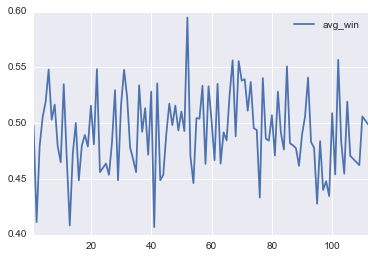

In [221]:
heroes.filter(['avg_win']).plot()

In [218]:
heroesPairs.sort_index().head()

,wins,defeats,w-d,all,avg_win
"(1, 2)",116,204.0,-88.0,320.0,0.362500
"(1, 3)",225,279.0,-54.0,504.0,0.446429
"(1, 4)",78,64.0,14.0,142.0,0.549296
"(1, 5)",231,217.0,14.0,448.0,0.515625
"(1, 6)",16,29.0,-13.0,45.0,0.355556


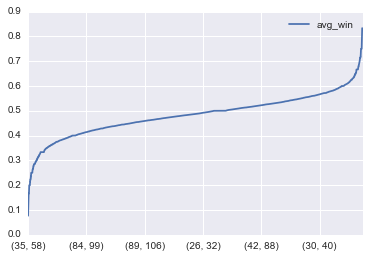

In [219]:
heroesPairs.sort_values(['avg_win']).filter(['avg_win']).plot()

In [17]:
def prepareHeroes(data, heroes):
    df = pd.DataFrame()
    for i, match_id in enumerate(data.index):
        for team in ['r', 'd']:
            rate = 0
            for i in range(1,6):
                rate += heroes.ix[data.ix[match_id, '{}{}_hero'.format(team, i)], 'avg_win']
            df.set_value(match_id, 'heroes_rate_{}'.format(team),  rate)
    
    return df

In [19]:
X_rated = prepareHeroes(train, heroes)

In [20]:
X_rated_test = prepareHeroes(X_test, heroes)

Проверим качество предсказания без мешка слов, так как теоретически мешок себя ведет как "скрытое" выведение качества героев. К сожалению качество стало хуже, чем у мешка, но лучше чем совсем без него. Значит метрика силы команды имеет смысл.

In [21]:
superX = pd.concat([X_rated, prepareData(X)], axis=1)
superX_test = pd.concat([X_rated_test, prepareData(X_test)], axis=1)
pred = trainLR(superX, y, superX_test, 0.112)
save("lr_with_heroes", pred, X_test) # 0.73908

In [224]:
superX = pd.concat([pd.DataFrame(bag, index=X.index), prepareData(X), X_rated], axis=1)
testLR(superX, y)

Best score: 0.7520986263567524
Best parameters: {'C': 0.112}


Kaggle оценил такое предсказание чуть лучше чем обычные мешок слов в 0.75500.

In [225]:
bag_test = wordsBag(X_test, 113)
superX_test = pd.concat([pd.DataFrame(bag_test, index=X_test.index), prepareData(X_test), X_rated_test], axis=1)
pred = trainLR(superX, y, superX_test, 0.112)
save("lr_with_bag_and_heroes", pred, X_test) # 0.75500

In [177]:
def prepareHeroesPairs(data, heroesPairs):
    df = pd.DataFrame()
    for i, match_id in enumerate(data.index):
        for team in ['r', 'd']:
            rate = 0
            for i in range(1,6):
                for j in range(i+1, 6):
                    a = data.ix[match_id, '{}{}_hero'.format(team, i)]
                    b = data.ix[match_id, '{}{}_hero'.format(team, j)]
                    r = heroesPairs.ix[[(a, b)], 'avg_win']
                    if pd.isnull(r).bool():
                        r = pd.Series(0.5, index=[(a,b)], name='avg_win')
                    rate += r[0]

            df.set_value(match_id, 'heroes_pair_rate_{}'.format(team),  rate)
    
    return df

In [180]:
X_rated_pairs = prepareHeroesPairs(train, heroesPairs)
X_rated_pairs.head()

,heroes_pair_rate_r,heroes_pair_rate_d
0,5.263939,4.916007
1,5.095252,4.869165
2,4.989413,5.310641
3,4.599543,5.341120
4,4.538724,4.969877


In [181]:
X_rated_pairs_test = prepareHeroes(X_test, heroes)
X_rated_pairs_test.head()

,heroes_rate_r,heroes_rate_d
6,2.638478,2.351951
7,2.538274,2.351078
10,2.343177,2.459007
13,2.490384,2.539148
16,2.578568,2.465709


In [217]:
superX = pd.concat([pd.DataFrame(bag, index=X.index), prepareData(X), X_rated, X_rated_pairs], axis=1)
superX_test = pd.concat([pd.DataFrame(bag_test, index=X_test.index), prepareData(X_test), X_rated_test, X_rated_pairs_test], axis=1)
testLR(superX, y)

Best score: 0.7580872564721051
Best parameters: {'C': 0.223}


In [223]:
pred = trainLR(superX, y, superX_test, 0.223)
save("lr_with_bag_and_heroes_and_pairs", pred, X_test) # 0.75357 - переобучился?

К сожалению добавочная оценка силы пар игроков только ухудшила предсказание. Возможно алгоритм переобучился. Мы слишком заточились на те пары, которые были в тестовой выборке и не оцениваем гибко ситуацию.
Конечно безумно любопытно, можно ли подсчитать синергию лучше, чем мешок слов.

Теоретически можно еще оценивать количество нанесеного урона башням, не знаю почему их не добавили в этот набор признаков.
Но итоговая оценка в 0.755 весьма приятна, хотя кажется можно выжать еще немного :)